In [1]:
import seaborn as sns
import torch
from sklearn.metrics import accuracy_score, f1_score, classification_report
from transformers import (AutoModelForSequenceClassification, AutoTokenizer,
                          DataCollatorWithPadding, Trainer, TrainingArguments)
import numpy as np

from data import SharedTaskData


/home/m0re/projects/phd/venvs/vargmining/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Prepare dataset

In [2]:
train_data = SharedTaskData("TaskA_train.csv")
dev_data = SharedTaskData("TaskA_dev.csv")

train_dataset_novelty = train_data.convert_to_hf_dataset("novelty")
train_dataset_validity = train_data.convert_to_hf_dataset("validity")
# Use feature mapping from training dataset to ensure features are mapped correctly
dev_dataset_novelty = dev_data.convert_to_hf_dataset("novelty", features=train_dataset_novelty.features)
dev_dataset_validity = dev_data.convert_to_hf_dataset("validity", features=train_dataset_validity.features)

# Make sure internal label mapping is identical across datasets
assert train_dataset_validity.features['validity_str']._str2int == dev_dataset_validity.features['validity_str']._str2int
assert train_dataset_novelty.features['novelty_str']._str2int == dev_dataset_novelty.features['novelty_str']._str2int

Parameter 'function'=<function map_label at 0x7f323f8bcc10> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
Casting the dataset: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 431.56ba/s]


{'deafisible': 0, 'not-valid': 1, 'valid': 2}


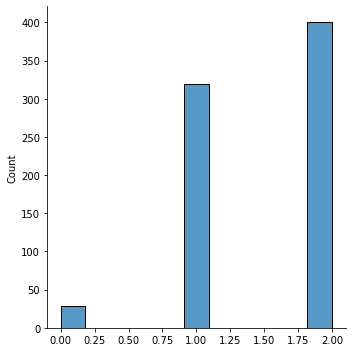

In [3]:
# investigate validity labels
print(train_dataset_validity.features['validity_str']._str2int)
sns.displot(train_dataset_validity['validity_str'])

{'borderline novel': 0, 'not-novel': 1, 'novel': 2}


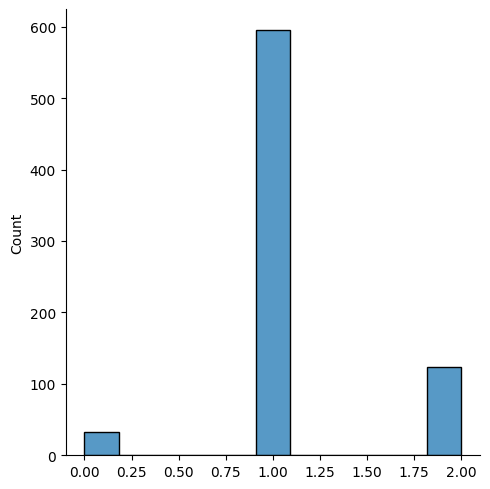

In [4]:
# .. and novelty labels
print(train_dataset_novelty.features['novelty_str']._str2int)
sns.displot(train_dataset_novelty['novelty_str'])

In [5]:
# Random Baseline novelty
print("Novelty")
y_true = np.array(dev_dataset_novelty['novelty_str'])
y_pred = np.random.randint(low=0, high=2, size=len(dev_dataset_novelty))
print(classification_report(y_true, y_pred))

# Random Baseline validity
print("Validity")
y_true = np.array(dev_dataset_validity['validity_str'])
y_pred = np.random.randint(low=0, high=2, size=len(dev_dataset_validity))
print(classification_report(y_true, y_pred))

# Majority Baseline novelty
print("Novelty")
y_true = np.array(dev_dataset_novelty['novelty_str'])
y_pred = np.array([train_dataset_novelty.features['novelty_str']._str2int['not-novel']] * len(dev_dataset_novelty))
print(classification_report(y_true, y_pred))

# Majority Baseline validity
print("Validity")
y_true = np.array(dev_dataset_validity['validity_str'])
y_pred = np.array([train_dataset_validity.features['validity_str']._str2int['valid']] * len(dev_dataset_validity))
print(classification_report(y_true, y_pred))

Novelty
              precision    recall  f1-score   support

           0       0.01      0.50      0.02         2
           1       0.56      0.47      0.51       118
           2       0.00      0.00      0.00        82

    accuracy                           0.28       202
   macro avg       0.19      0.32      0.18       202
weighted avg       0.32      0.28      0.30       202

Validity
              precision    recall  f1-score   support

           0       0.02      0.67      0.04         3
           1       0.37      0.53      0.44        74
           2       0.00      0.00      0.00       125

    accuracy                           0.20       202
   macro avg       0.13      0.40      0.16       202
weighted avg       0.14      0.20      0.16       202

Novelty
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.58      1.00      0.74       118
           2       0.00      0.00      0.00       

/home/m0re/projects/phd/venvs/vargmining/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/m0re/projects/phd/venvs/vargmining/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/m0re/projects/phd/venvs/vargmining/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

# Data imbalance
We suffer from some data imbalance so we may need to oversample.

In [6]:
# We focus on predicting Validity label for now
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, 
    num_labels=train_dataset_validity.features['validity_str'].num_classes,
    label2id=train_dataset_validity.features['validity_str']._str2int, 
    id2label={v:k for k, v in train_dataset_validity.features['validity_str']._str2int.items()},
)


def tokenize_function_val(examples):
    batch_size = len(examples['Premise'])
    batched_inputs = [
        examples['topic'][i] + tokenizer.sep_token + \
        examples['Premise'][i] + tokenizer.sep_token + \
        examples['Conclusion'][i] for i in range(batch_size)
    ]
    samples = tokenizer(batched_inputs, truncation=True, padding=True)
    samples['labels'] = examples['validity_str']
    return samples 

def tokenize_function_nov(examples):
    batch_size = len(examples['Premise'])
    batched_inputs = [
        examples['topic'][i] + tokenizer.sep_token + \
        examples['Premise'][i] + tokenizer.sep_token + \
        examples['Conclusion'][i] for i in range(batch_size)
    ]
    samples = tokenizer(batched_inputs, truncation=True, padding=True)
    samples['labels'] = examples['novelty_str']
    return samples 


tokenized_train_dataset_validity = train_dataset_validity.map(tokenize_function_val, batched=True)
tokenized_dev_dataset_validity = dev_dataset_validity.map(tokenize_function_val, batched=True)
tokenized_train_dataset_validity.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
tokenized_dev_dataset_validity.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
tokenized_train_dataset_novelty = train_dataset_novelty.map(tokenize_function_nov, batched=True)
tokenized_dev_dataset_novelty = dev_dataset_novelty.map(tokenize_function_nov, batched=True)
tokenized_train_dataset_novelty.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
tokenized_dev_dataset_novelty.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [7]:
# define metrics

def single_label_metrics(predictions, labels):
    softmax = torch.nn.Softmax(dim=1)
    preds = torch.Tensor(predictions)
    probs = softmax(preds)
    y_pred = torch.argmax(probs, dim=1)
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    accuracy = accuracy_score(y_true, y_pred)
    return {'f1': f1_micro_average, 'accuracy': accuracy}

def compute_metrics(p):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    return single_label_metrics(
        predictions=preds, 
        labels=p.label_ids
    )

In [ ]:
training_args = TrainingArguments(
    "argmining2022_trainer",
    num_train_epochs=10,
    logging_strategy="epoch",
    evaluation_strategy="epoch",
    save_strategy="epoch",
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_train_dataset_validity,
    eval_dataset=tokenized_dev_dataset_validity,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

# Multi-Task Learning
Code inspired by [here](https://colab.research.google.com/github/zphang/zphang.github.io/blob/master/files/notebooks/Multi_task_Training_with_Transformers_NLP.ipynb#scrollTo=yrtS3ZeSsoZw).


In [8]:
from models import MultitaskModel
from trainers import MultitaskTrainer, NLPDataCollator
import transformers

In [9]:
model_name = "roberta-base"
multitask_model = MultitaskModel.create(
    model_name=model_name,
    model_type_dict={
        "novelty": transformers.AutoModelForSequenceClassification,
        "validity": transformers.AutoModelForSequenceClassification,
    },
    model_config_dict={
        "novelty": transformers.AutoConfig.from_pretrained(model_name, num_labels=2),
        "validity": transformers.AutoConfig.from_pretrained(model_name, num_labels=2),
    },
)

if model_name.startswith("roberta-"):
    print(multitask_model.encoder.embeddings.word_embeddings.weight.data_ptr())
    print(multitask_model.taskmodels_dict["novelty"].roberta.embeddings.word_embeddings.weight.data_ptr())
    print(multitask_model.taskmodels_dict["validity"].roberta.embeddings.word_embeddings.weight.data_ptr())
else:
    print("Exercise for the reader: add a check for other model architectures =)")

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

139850758737984
139850758737984
139850758737984


In [10]:
train_dataset = {
    "validity": tokenized_train_dataset_validity,
    "novelty": tokenized_train_dataset_novelty
}
trainer = MultitaskTrainer(
    model=multitask_model,
    args=transformers.TrainingArguments(
        output_dir="./models/multitask_model",
        overwrite_output_dir=True,
        learning_rate=1e-5,
        do_train=True,
        num_train_epochs=3,
        # Adjust batch size if this doesn't fit on the Colab GPU
        per_device_train_batch_size=8,  
        save_steps=3000,
    ),
    data_collator=NLPDataCollator(),
    train_dataset=train_dataset,
)

/home/m0re/projects/phd/venvs/vargmining/lib/python3.9/site-packages/torch/cuda/__init__.py:145: UserWarning: 
NVIDIA GeForce RTX 3050 Ti Laptop GPU with CUDA capability sm_86 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the NVIDIA GeForce RTX 3050 Ti Laptop GPU GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


In [11]:
trainer.train()

/home/m0re/projects/phd/venvs/vargmining/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1500
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 564


test


RuntimeError: CUDA error: no kernel image is available for execution on the device
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.